In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.io import loadmat,savemat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import to_categorical
import random
from tensorflow.keras.models import load_model
from numpy import argmax
from tensorflow.keras.callbacks import EarlyStopping

Using plaidml.keras.backend backend.


In [2]:
usable_class = 0

architecture = [(100,100,100,100,100)] #(100,100),(100,100,100,100,100),(500,500),(1000,1000))

lossfcns = ['mean_size_loss']

herestr = %pwd

pickle_string_class = '/Users/chorvat/Dropbox (Brown)/Research Projects/Active/Data/Neural_Net_Data/Training_Pickles/Use_Conc/Classifier/'
pickle_string_full = '/Users/chorvat/Dropbox (Brown)/Research Projects/Active/Data/Neural_Net_Data/Training_Pickles/Use_Conc/Full_Network/'
training_string = '/Users/chorvat/Dropbox (Brown)/Research Projects/Active/Data/Neural_Net_Data/6-hourly-2009/Training_converged.mat'
misc_string = '../../NN_params.mat'

In [3]:
# Custom loss function

def mean_size_loss(y_true,y_pred):

    print(y_true)
        
    mfs_true = tf.multiply(y_true,Rcent.T)
    mfs_pred = tf.multiply(y_pred,Rcent.T)
    
    
    loss = tf.reduce_sum(abs(mfs_true - mfs_pred),axis=-1)
    
    # Return a function
    return loss

In [4]:
import h5py

# training_data = loadmat(training_string)
training_data = h5py.File(training_string, 'r')
misc_data = loadmat(misc_string)


In [5]:
input_vec = training_data['in'][()].T
output_vec = training_data['out'][()].T

Freq = misc_data['f']
dFreq = Freq * (np.sqrt(1.1) - np.sqrt(1/1.1)); 
# Redge = misc_data['redge'].T
Rcent = misc_data['rcent_12'].T
# Lambda = misc_data['lambda']

num_frac = np.sum(output_vec,axis=1)

usable = num_frac > 0
print('Out of ' + str(len(num_frac)) + ', ' + str(sum(usable)) + ' can be used')

NN_input = input_vec[usable,:27] # First 25 are spectrum, 26 is thickness, 27 is conc
NN_output = output_vec[usable]

Out of 5087436, 2660124 can be used


In [6]:
# Make sure we keep the training and test data the same at all times
import pickle

try:

    X_train = pickle.load( open( pickle_string_full + "X_train.p", "rb" ) )
    X_test = pickle.load( open( pickle_string_full + "X_test.p", "rb" ) )
    y_train = pickle.load( open(pickle_string_full + "y_train.p","rb"))
    y_test = pickle.load( open(pickle_string_full + "y_test.p","rb"))
    
except:
        
        print('exception in loading segmented data')
        X_train, X_test, y_train, y_test = train_test_split(NN_input,NN_output,test_size=0.3)
        
        pickle.dump(X_train, open(pickle_string_full + "X_train.p", "wb" ) )
        pickle.dump(X_test, open(pickle_string_full + "X_test.p", "wb" ) )
        pickle.dump(y_train, open(pickle_string_full + "y_train.p", "wb" ) )
        pickle.dump(y_test, open(pickle_string_full + "y_test.p", "wb" ) )

In [13]:
for structno in range(len(architecture)):

    struct = architecture[structno]
    
    if isinstance(struct,int):
        struct = [struct]
    
    print('Size is ' + str(struct))

    for lossno in range(len(lossfcns)):
    
    
        NN_fullnet = Sequential();
        #First Hidden Layer
        NN_fullnet.add(Dense(struct[0], activation='relu', kernel_initializer='random_normal', input_dim=27));
        print('Adding layer with size ' + str(struct[0]))

        #Other Hidden Layers
        for i in range(len(struct)-1):
            print('Adding layer with size ' + str(struct[i+1]))
            NN_fullnet.add(Dense(struct[i+1], activation='relu', kernel_initializer='random_normal'));

        #Output Layer
        NN_fullnet.add(Dense(12, activation='softmax', kernel_initializer='random_normal'));

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10);

        if lossfcns[lossno] == 'mean_size_loss':
        
            NN_fullnet.compile(optimizer ='adam',loss=mean_size_loss)
        
        else:
        
            NN_fullnet.compile(optimizer ='adam',loss=lossfcns[lossno])

        
        # Output name
        outstr = 'Full-'

        for i in range(len(struct)):
            outstr = outstr + str(struct[i]) + 'x'

        outstr = outstr[:-1] + '-' + lossfcns[lossno]     
        
        fname = 'Networks/' + outstr + '.h5'

        history = NN_fullnet.fit(X_train,y_train,validation_data = (X_test,y_test),batch_size=2048, epochs=250,callbacks=[es])
        
        NN_fullnet.save(fname)

Size is (100, 100, 100, 100, 100)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Adding layer with size 100
Adding layer with size 100
Adding layer with size 100
Adding layer with size 100
Adding layer with size 100
Tensor("dense_5_target:0", shape=(?, ?), dtype=float32)
Train on 1862086 samples, validate on 798038 samples
Epoch 1/250
  94208/1862086 [>.............................] - ETA: 29s - loss: 149.0964

KeyboardInterrupt: 

29.73557388693502

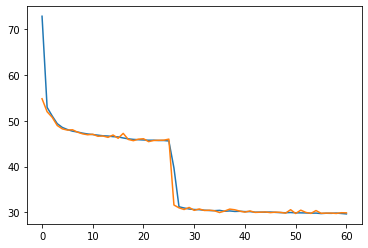

In [10]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
np.min(history.history['val_loss'])

In [7]:
NN_fullnet = load_model('Networks/Full-100x100x100x100x100-mean_size_loss.h5',custom_objects={'mean_size_loss':mean_size_loss})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Tensor("dense_11_target:0", shape=(?, ?), dtype=float32)


SAE value here is [9.91978282]


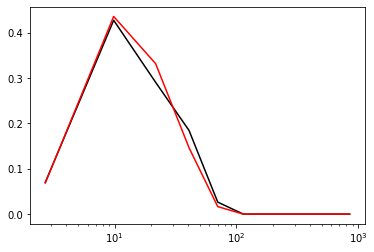

In [10]:
q = random.randint(0,y_test.shape[0])
plt.semilogx(Rcent,y_test[q,:],color='k')

test_out = NN_fullnet.predict(np.expand_dims(X_test[q,:],axis=1).T).T

plt.semilogx(Rcent,test_out,color='r')

print('SAE value here is ' + str(100*sum(abs(np.subtract(np.expand_dims(y_test[q,:],axis=1),test_out)))))

In [11]:

test_out = NN_fullnet.predict(X_test)

y_test_norm = np.divide(y_test,np.expand_dims(np.sum(y_test,axis=1),axis=1))



In [17]:
errmat = np.sum(np.abs((test_out - y_test_norm)),axis=1)
errmat2 = np.mean((test_out - y_test_norm)**2,axis=1)
testE = np.sum(X_test[:,:25]*dFreq.T,axis=1)
testH = X_test[:,-2]
testC = X_test[:,-1]

# print(errmat.shape)
print(testE.shape)
print(testH.shape)

print('SAE is: ' + str(np.nanmean(errmat)))
print('MSE is: ' + str(np.nanmean(errmat2)))


(798038,)
(798038,)
SAE is: 0.14570428509598785
MSE is: 0.0012340455609749605


/Users/chorvat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/Users/chorvat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/Users/chorvat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/chorvat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice
/Users/chorvat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/Users/chorvat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: Mean of empty slice


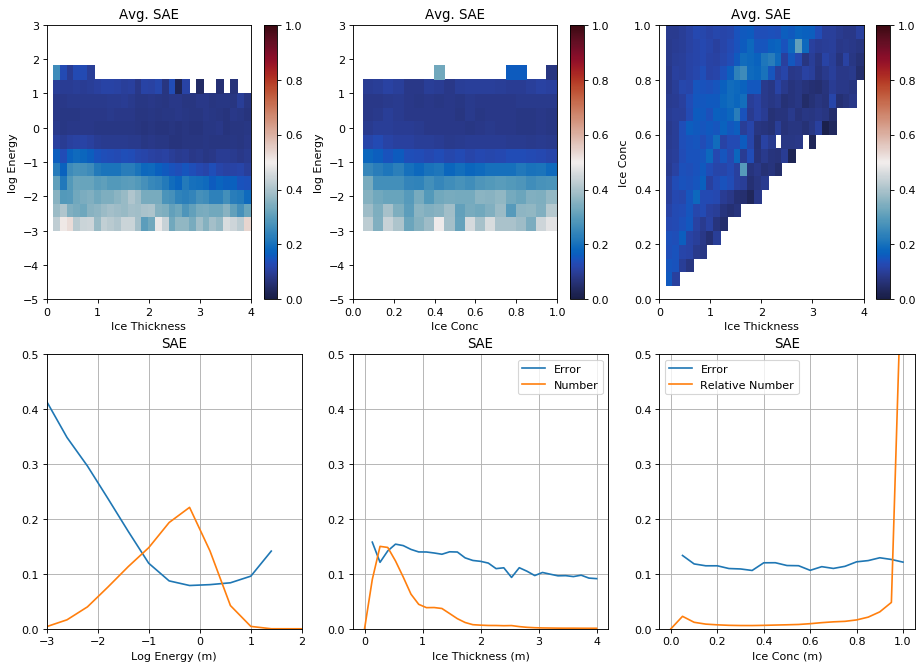

In [18]:
import cmocean 

Ebins = np.linspace(-5,3,21)
Hbins = np.linspace(0,4,31)
Cbins = np.linspace(0,1,21)

Eloc = np.digitize(np.log10(testE),Ebins,right=True)
Hloc = np.digitize(testH,Hbins,right=True)
Cloc = np.digitize(testC,Cbins,right=True)

thresher = np.argmax(Ebins>-2)

accummat_error_EH = np.zeros((len(Ebins),len(Hbins)))
accummat_num_EH = np.zeros((len(Ebins),len(Hbins)))

accummat_error_EC = np.zeros((len(Ebins),len(Cbins)))
accummat_num_EC = np.zeros((len(Ebins),len(Cbins)))

accummat_error_CH = np.zeros((len(Cbins),len(Hbins)))
accummat_num_CH = np.zeros((len(Cbins),len(Hbins)))

for i in range(len(Ebins)):
    for j in range(len(Hbins)):
        accummat_error_EH[i,j] = np.nanmean(errmat[(Eloc==i)& (Hloc==j)])
        accummat_num_EH[i,j] = len(errmat[(Eloc==i)& (Hloc==j)])
  
for i in range(len(Ebins)):
    for j in range(len(Cbins)):
        accummat_error_EC[i,j] = np.nanmean(errmat[(Eloc==i)& (Cloc==j)])
        accummat_num_EC[i,j] = len(errmat[(Eloc==i)& (Cloc==j)])

for i in range(len(Cbins)):
    for j in range(len(Hbins)):
        accummat_error_CH[i,j] = np.nanmean(errmat[(Cloc==i)& (Hloc==j)&(Eloc>=thresher)])
        accummat_num_CH[i,j] = len(errmat[(Cloc==i)& (Hloc==j)&(Eloc>=thresher)])


accummat_num_EH = accummat_num_EH / np.nansum(accummat_num_EH) 
accummat_num_EC = accummat_num_EC / np.nansum(accummat_num_EC)
accummat_num_CH = accummat_num_CH / np.nansum(accummat_num_CH)

fig = plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k');

plt.subplot(231)
plt.pcolormesh(Hbins,Ebins,accummat_error_EH,cmap='cmo.balance');
plt.colorbar()
plt.title('Avg. SAE');
plt.xlabel('Ice Thickness')
plt.ylabel('log Energy')
plt.clim([0,1])

plt.subplot(232)
plt.pcolormesh(Cbins,Ebins,accummat_error_EC,cmap='cmo.balance');
plt.colorbar()
plt.title('Avg. SAE');
plt.xlabel('Ice Conc')
plt.ylabel('log Energy')
plt.clim([0,1])

plt.subplot(233)
plt.pcolormesh(Hbins,Cbins,accummat_error_CH,cmap='cmo.balance');
plt.colorbar()
plt.title('Avg. SAE');
plt.xlabel('Ice Thickness')
plt.ylabel('Ice Conc')
plt.clim([0,1])

plt.subplot(234)
plotter = np.nanmean(accummat_error_EH,axis=1);
plt.plot(Ebins,plotter)
plotter = np.nansum(accummat_num_EH,axis=1)
plt.plot(Ebins,plotter)
plt.title('SAE')
plt.xlabel('Log Energy (m)')
plt.ylim([0,.5])
plt.xlim([-3,2])
plt.grid()

plt.subplot(235)
plotter = np.nanmean(accummat_error_EH[thresher:,:],axis=0);
plt.plot(Hbins,plotter)
plotter = np.nansum(accummat_num_EH[thresher:,:],axis=0)
plt.plot(Hbins,plotter)
plt.title('SAE')
plt.xlabel('Ice Thickness (m)')
plt.ylim([0,.5])
plt.legend(('Error','Number'))


plt.grid()

plt.subplot(236)
plotter = np.nanmean(accummat_error_CH[:,:],axis=1);
plt.plot(Cbins,plotter)
plotter = np.nansum(accummat_num_CH[:,:],axis=1)
plt.plot(Cbins,plotter)
plt.title('SAE')
plt.xlabel('Ice Conc (m)')
plt.ylim([0,.5])
plt.legend(('Error','Relative Number'))

plt.grid()

#fig.tight_layout()
plt.savefig('Fullnet-Error-withlast.pdf')

In [45]:
np.nansum(y_test*Rcent.T)/1000

17410.424876734312

In [46]:
lossfcns[0]

'mae'

In [47]:
thresher = np.argmax(Ebins>-2)
print(thresher)

8


In [15]:
save_string = '/Users/chorvat/Dropbox (Brown)/Research Projects/Active/Data/Neural_Net_Data/6-hourly-2009/NN-results.mat'
mdic = {"Y_true": y_test, "Y_pred": test_out, "X_test":X_test}
savemat(save_string,mdic)
